### Convolutional networks

This is an annotated version of Keras's [example MNIST CNN code](https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py) for how to implement convolutional networks.

The CIFAR-10 classification task is a classic machine learning benchmark. The data includes 50,000 images belonging to 10 classes, and the task is to identify them. Along with MNIST, CIFAR-10 classification is a sort of like a "hello world" for computer vision and convolutional networks, so a solution can be implemented quickly with an off-the-shelf machine learning library.

Since convolutional neural networks have thus far proven to be the best at computer vision tasks, we'll use the Keras library to implement a convolutional networks as our solution. Keras provides a well-designed and readable API on top of TensorFlow's backend, so we'll be done in a surprisingly short amount of steps!

Note, if you have been running these notebooks on a regular laptop without GPU until now, it's going to become more and more difficult to do so. The neural networks we will be training, starting with convolutional networks, will become increasingly memory and processing-intensive and may slow down laptops without good graphics processing. 

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import random

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Conv2D, MaxPooling2D, Flatten

from keras.layers import Activation


Recall that a basic neural network in Keras can be set up like this:

In [2]:
model = Sequential()
model.add(Dense(100, activation='sigmoid', input_dim=3072))
model.add(Dense(100, activation='sigmoid'))
model.add(Dense(10, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               307300    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 318,410
Trainable params: 318,410
Non-trainable params: 0
_________________________________________________________________


We load CIFAR-10 dataset and reshape them as individual vectors.

Let's see some of our samples.

In [3]:
from keras.datasets import cifar10

# load CIFAR
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
num_classes = 10

# reshape CIFAR
x_train = x_train.reshape(50000, 32*32*3)
x_test = x_test.reshape(10000, 32*32*3)

# make float32
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# normalize to (0-1)
x_train /= 255
x_test /= 255

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print('%d train samples, %d test samples'%(x_train.shape[0], x_test.shape[0]))
print("training data shape: ", x_train.shape, y_train.shape)
print("test data shape: ", x_test.shape, y_test.shape)

170500096/170498071 [==============================] - 2s 0us/step
50000 train samples, 10000 test samples
training data shape:  (50000, 3072) (50000, 10)
test data shape:  (10000, 3072) (10000, 10)


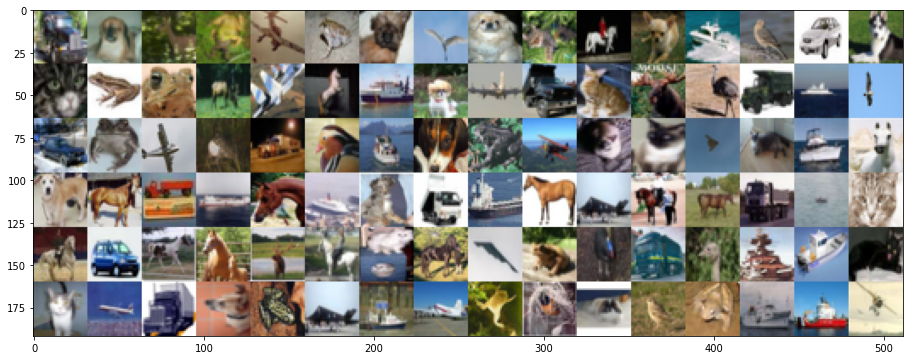

In [4]:
samples = np.concatenate([np.concatenate([x_train[i].reshape((32,32,3)) for i in [int(random.random() * len(x_train)) for i in range(16)]], axis=1) for i in range(6)], axis=0)
plt.figure(figsize=(16,6))
plt.imshow(samples, cmap='gray')

We can compile the model using categorical-cross-entropy loss, and train it for 30 epochs.

In [5]:
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=128,
          epochs=30,
          validation_data=(x_test, y_test))


Epoch 1/30
391/391 [==============================] - 1s 4ms/step - loss: 2.2976 - accuracy: 0.1575 - val_loss: 2.2778 - val_accuracy: 0.1793
Epoch 2/30
391/391 [==============================] - 1s 4ms/step - loss: 2.2649 - accuracy: 0.2024 - val_loss: 2.2512 - val_accuracy: 0.2210
Epoch 3/30
391/391 [==============================] - 1s 4ms/step - loss: 2.2376 - accuracy: 0.2260 - val_loss: 2.2223 - val_accuracy: 0.2477
Epoch 4/30
391/391 [==============================] - 1s 4ms/step - loss: 2.2056 - accuracy: 0.2431 - val_loss: 2.1877 - val_accuracy: 0.2646
Epoch 5/30
391/391 [==============================] - 1s 3ms/step - loss: 2.1693 - accuracy: 0.2573 - val_loss: 2.1510 - val_accuracy: 0.2537
Epoch 6/30
391/391 [==============================] - 1s 4ms/step - loss: 2.1330 - accuracy: 0.2664 - val_loss: 2.1165 - val_accuracy: 0.2754
Epoch 7/30
391/391 [==============================] - 1s 3ms/step - loss: 2.1004 - accuracy: 0.2785 - val_loss: 2.0860 - val_accuracy: 0.2776
Epoch 

Then we can evaluate the model.

In [6]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.8420300483703613
Test accuracy: 0.3483999967575073


Not very good! With more training time, perhaps 100 epochs, we might get 40% accuracy.  

Now onto convolutional networks... The general architecture of a convolutional neural network is:

- convolution layers, followed by pooling layers
- fully-connected layers
- a final fully-connected softmax layer

We'll follow this same basic structure and interweave some other components, such as [dropout](https://en.wikipedia.org/wiki/Dropout_(neural_networks), to improve performance.

To begin, we start with our convolution layers. We first need to specify some architectural hyperparemeters:

- _How many filters do we want for our convolution layers?_ Like most hyperparameters, this is chosen through a mix of intuition and tuning. A rough rule of thumb is: the more complex the task, the more filters. (Note that we don't need to have the same number of filters for each convolution layer, but we are doing so here for convenience.)
- _What size should our convolution filters be?_ We don't want filters to be too large or the resulting matrix might not be very meaningful. For instance, a useless filter size in this task would be a 28x28 filter since it covers the whole image. We also don't want filters to be too small for a similar reason, e.g. a 1x1 filter just returns each pixel.
- _What size should our pooling window be?_ Again, we don't want pooling windows to be too large or we'll be throwing away information. However, for larger images, a larger pooling window might be appropriate (same goes for convolution filters).

We start by designing a neural network with two alternating convolutional and max-pooling layers, followed by a 100-neuron fully-connected layer and a 10-neuron output. We'll have 64 and 32 filters in the two convolutional layers, and make the input shape a full-sized image (32x32x3) instead of an unrolled vector (3072x1).  We also now use ReLU activation units instead of sigmoids, to avoid vanishing gradients.

In [7]:
model = Sequential()
model.add(Conv2D(64, (3, 3), padding='same', input_shape=(32,32,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
activation (Activation)      (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        18464     
_________________________________________________________________
activation_1 (Activation)    (None, 16, 16, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)             

We need to reload the CIFAR-10 dataset and this time do *not* reshape them into unrolled input vectors -- let them stay as images, although continue to normalize them.

In [8]:
from keras.datasets import cifar10

# load CIFAR
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
num_classes = 10

# do not reshape CIFAR if you have a convolutional input!

# make float32
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# normalize to (0-1)
x_train /= 255
x_test /= 255

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print('%d train samples, %d test samples'%(x_train.shape[0], x_test.shape[0]))
print("training data shape: ", x_train.shape, y_train.shape)
print("test data shape: ", x_test.shape, y_test.shape)

50000 train samples, 10000 test samples
training data shape:  (50000, 32, 32, 3) (50000, 10)
test data shape:  (10000, 32, 32, 3) (10000, 10)


Let's compile the model and test it again.

In [9]:
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=128,
          epochs=30,
          validation_data=(x_test, y_test))

Epoch 1/30
391/391 [==============================] - 3s 7ms/step - loss: 2.2070 - accuracy: 0.1984 - val_loss: 2.0382 - val_accuracy: 0.2647
Epoch 2/30
391/391 [==============================] - 2s 6ms/step - loss: 1.9641 - accuracy: 0.2996 - val_loss: 1.8953 - val_accuracy: 0.3317
Epoch 3/30
391/391 [==============================] - 2s 6ms/step - loss: 1.8424 - accuracy: 0.3534 - val_loss: 1.8036 - val_accuracy: 0.3623
Epoch 4/30
391/391 [==============================] - 2s 6ms/step - loss: 1.7287 - accuracy: 0.3944 - val_loss: 1.6654 - val_accuracy: 0.4161
Epoch 5/30
391/391 [==============================] - 2s 6ms/step - loss: 1.6356 - accuracy: 0.4245 - val_loss: 1.6148 - val_accuracy: 0.4342
Epoch 6/30
391/391 [==============================] - 2s 6ms/step - loss: 1.5559 - accuracy: 0.4499 - val_loss: 1.5356 - val_accuracy: 0.4460
Epoch 7/30
391/391 [==============================] - 3s 6ms/step - loss: 1.4903 - accuracy: 0.4713 - val_loss: 1.4559 - val_accuracy: 0.4805
Epoch 

Let's evaluate the model again.

In [10]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.049064040184021
Test accuracy: 0.6327999830245972


63% accuracy is a big improvement on 40%! All of that is accomplished in just 30 epochs using convolutional layers and ReLUs. 

Let's try to make the network bigger.

In [11]:
model = Sequential()
model.add(Conv2D(128, (3, 3), padding='same', input_shape=(32,32,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 32, 32, 128)       3584      
_________________________________________________________________
activation_4 (Activation)    (None, 32, 32, 128)       0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        73792     
_________________________________________________________________
activation_5 (Activation)    (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 64)         

Compile and train again.

In [12]:

model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=128,
          epochs=50,
          validation_data=(x_test, y_test))

Epoch 1/50
391/391 [==============================] - 4s 10ms/step - loss: 2.2636 - accuracy: 0.1841 - val_loss: 2.1789 - val_accuracy: 0.2362
Epoch 2/50
391/391 [==============================] - 4s 10ms/step - loss: 2.0475 - accuracy: 0.2637 - val_loss: 1.9485 - val_accuracy: 0.3148
Epoch 3/50
391/391 [==============================] - 4s 10ms/step - loss: 1.8778 - accuracy: 0.3297 - val_loss: 1.8027 - val_accuracy: 0.3507
Epoch 4/50
391/391 [==============================] - 4s 10ms/step - loss: 1.7586 - accuracy: 0.3721 - val_loss: 1.6654 - val_accuracy: 0.4132
Epoch 5/50
391/391 [==============================] - 4s 10ms/step - loss: 1.6492 - accuracy: 0.4088 - val_loss: 1.5886 - val_accuracy: 0.4241
Epoch 6/50
391/391 [==============================] - 4s 10ms/step - loss: 1.5696 - accuracy: 0.4370 - val_loss: 1.5989 - val_accuracy: 0.4314
Epoch 7/50
391/391 [==============================] - 4s 10ms/step - loss: 1.5049 - accuracy: 0.4622 - val_loss: 1.5984 - val_accuracy: 0.4237

Evaluate test accuracy.

In [13]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.9439065456390381
Test accuracy: 0.6880999803543091


One problem you might notice is that the accuracy of the model is much better on the training set than on the test set. You can see that by monitoring the progress at the end of each epoch above or by evaluating it directly.

In [14]:
score = model.evaluate(x_train, y_train, verbose=0)
print('Training loss:', score[0])
print('Training accuracy:', score[1])

Training loss: 0.5990909934043884
Training accuracy: 0.7929999828338623


77% accuracy on the training set but only 68% on the test set. Looking at the monitored training, the validation accuracy and training accuracy began to diverge around epoch 10.

Something must be wrong!  This is a symptom of "overfitting".  Our model has probably tried to bend itself a little too well towards predicting the training set but does not generalize very well to unseen data. This is a very common problem. 

It's normal for the training accuracy to be better than the testng accuracy to some degree, because it's hard to avoid for the network to be better at predicting the data it sees. But a 9% difference is too much.

One way of helping this is by doing some regularization. We can add dropout to our model after a few layers.

In [15]:
model = Sequential()
model.add(Conv2D(128, (3, 3), padding='same', input_shape=(32,32,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 128)       3584      
_________________________________________________________________
activation_10 (Activation)   (None, 32, 32, 128)       0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 64)        73792     
_________________________________________________________________
activation_11 (Activation)   (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 64)         

We compile and train again.

In [16]:

model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=128,
          epochs=50,
          validation_data=(x_test, y_test))

Epoch 1/50
391/391 [==============================] - 4s 10ms/step - loss: 2.2916 - accuracy: 0.1367 - val_loss: 2.2661 - val_accuracy: 0.1848
Epoch 2/50
391/391 [==============================] - 4s 10ms/step - loss: 2.2015 - accuracy: 0.1955 - val_loss: 2.0450 - val_accuracy: 0.2729
Epoch 3/50
391/391 [==============================] - 4s 10ms/step - loss: 2.0432 - accuracy: 0.2445 - val_loss: 1.9208 - val_accuracy: 0.3171
Epoch 4/50
391/391 [==============================] - 4s 10ms/step - loss: 1.9404 - accuracy: 0.2914 - val_loss: 1.8271 - val_accuracy: 0.3552
Epoch 5/50
391/391 [==============================] - 4s 10ms/step - loss: 1.8518 - accuracy: 0.3259 - val_loss: 1.7299 - val_accuracy: 0.3860
Epoch 6/50
391/391 [==============================] - 4s 10ms/step - loss: 1.7843 - accuracy: 0.3496 - val_loss: 1.6492 - val_accuracy: 0.4141
Epoch 7/50
391/391 [==============================] - 4s 10ms/step - loss: 1.7267 - accuracy: 0.3717 - val_loss: 1.6453 - val_accuracy: 0.4139

We check our test loss and training loss again.

*   List item
*   List item

---



---





In [17]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

score = model.evaluate(x_train, y_train, verbose=0)
print('Training loss:', score[0])
print('Training accuracy:', score[1])

Test loss: 0.8850322961807251
Test accuracy: 0.6922000050544739
Training loss: 0.7964460849761963
Training accuracy: 0.7231600284576416


Now our training accuracy is lower (72%) but our test accuracy is higher (69%).  This is more like what we expect.

In [18]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

score = model.evaluate(x_train, y_train, verbose=0)
print('Training loss:', score[0])
print('Training accuracy:', score[1])

Test loss: 0.8850322961807251
Test accuracy: 0.6922000050544739
Training loss: 0.7964460849761963
Training accuracy: 0.7231600284576416


Another way of improving performance is to experiment with different optimizers beyond just standard sgd. Let's try to instantiate the same network but use ADAM instead of sgd.

In [19]:
model = Sequential()
model.add(Conv2D(128, (3, 3), padding='same', input_shape=(32,32,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary()


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 32, 32, 128)       3584      
_________________________________________________________________
activation_16 (Activation)   (None, 32, 32, 128)       0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 64)        73792     
_________________________________________________________________
activation_17 (Activation)   (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 8, 8, 64)         

In [20]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.fit(x_train, y_train,
          batch_size=128,
          epochs=50,
          validation_data=(x_test, y_test))


Epoch 1/50
391/391 [==============================] - 4s 11ms/step - loss: 1.6624 - accuracy: 0.3870 - val_loss: 1.2906 - val_accuracy: 0.5312
Epoch 2/50
391/391 [==============================] - 4s 10ms/step - loss: 1.2534 - accuracy: 0.5517 - val_loss: 1.1221 - val_accuracy: 0.5968
Epoch 3/50
391/391 [==============================] - 4s 10ms/step - loss: 1.0529 - accuracy: 0.6285 - val_loss: 0.9421 - val_accuracy: 0.6716
Epoch 4/50
391/391 [==============================] - 4s 10ms/step - loss: 0.9387 - accuracy: 0.6712 - val_loss: 0.8573 - val_accuracy: 0.6988
Epoch 5/50
391/391 [==============================] - 4s 10ms/step - loss: 0.8458 - accuracy: 0.7044 - val_loss: 0.7911 - val_accuracy: 0.7229
Epoch 6/50
391/391 [==============================] - 4s 10ms/step - loss: 0.7742 - accuracy: 0.7308 - val_loss: 0.7695 - val_accuracy: 0.7307
Epoch 7/50
391/391 [==============================] - 4s 10ms/step - loss: 0.7267 - accuracy: 0.7470 - val_loss: 0.7873 - val_accuracy: 0.7217

In [21]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

score = model.evaluate(x_train, y_train, verbose=0)
print('Training loss:', score[0])
print('Training accuracy:', score[1])

Test loss: 0.9876985549926758
Test accuracy: 0.776199996471405
Training loss: 0.025493517518043518
Training accuracy: 0.9945200085639954


78% accuracy! Our best yet. Looks heavily overfit though (99% accuracy on the training set... maybe needs more dropout?) 

Still a long way to go to beat the [record](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#43494641522d3130) (96%).  We can make a lot of progress by making the network (much) bigger, training for (much) longer and using a lot of little tricks (like data augmentation) but that is beyond the scope of this lesson for now.

Let's also recall how to predict a single value and look at its probabilities.

all probs [[3.9748144e-08 1.1459415e-08 3.0935464e-08 7.3911399e-01 2.1847983e-10
  2.6084125e-01 4.1539646e-05 4.7319816e-08 7.6448430e-07 2.3079374e-06]]
predicted = 3, actual = 3


<BarContainer object of 10 artists>

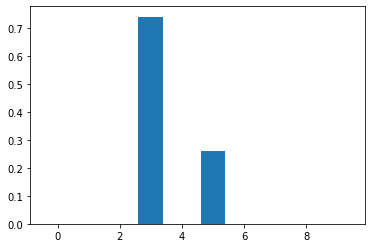

In [22]:
import matplotlib
x_sample = x_test[0].reshape(1,32,32,3)
y_probs = model.predict(x_sample)
y_prob = y_probs[0]
y_pred = y_prob.argmax()
y_actual = y_test[0].argmax()

print(f"all probs {y_probs}")
print("predicted = %d, actual = %d" % (y_pred, y_actual))
matplotlib.pyplot.bar(range(10), y_prob)

Let's also review here how to save and load trained keras models. It's easy! From [Keras docuemtnation](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model)

In [23]:
from keras.models import load_model

model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'
del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
model = load_model('my_model.h5')

# Option 3 (Advanced)
Take the code from a tutorial (such as one of the ones listed above), and try to change some of the parameters.

In [45]:
model = Sequential()

model.add(Conv2D(128, (3, 3), padding='same', input_shape=(32,32,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), padding='same')) # changed filters from 64 --> 128
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), padding='same')) # changed filters from 64 --> 128
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.35)) # added dropout layer
model.add(Conv2D(64, (3, 3), padding='same')) # added additional conv layer 
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.35)) # changed the dropout from 0.25 --> 0.35
model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dense(100))
model.add(Activation('relu'))
'''
model.add(Dense(75)) # added an additional dense layer with 75 neurons 
model.add(Activation('relu'))

model.add(Dropout(0.3)) # added a dropout layer
model.add(Dense(50)) # added an additional dense layer with 50 neurons 
model.add(Activation('relu'))
'''
model.add(Dropout(0.3)) # changed the dropout from 0.25 --> 0.3
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 32, 32, 128)       3584      
_________________________________________________________________
activation_76 (Activation)   (None, 32, 32, 128)       0         
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 16, 16, 128)       147584    
_________________________________________________________________
activation_77 (Activation)   (None, 16, 16, 128)       0         
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 8, 8, 128)       

In [46]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.fit(x_train, y_train,
          batch_size=128,
          epochs=50,
          validation_data=(x_test, y_test))

Epoch 1/50
391/391 [==============================] - 5s 13ms/step - loss: 1.8300 - accuracy: 0.3146 - val_loss: 1.3910 - val_accuracy: 0.4970
Epoch 2/50
391/391 [==============================] - 5s 13ms/step - loss: 1.3640 - accuracy: 0.5028 - val_loss: 1.1550 - val_accuracy: 0.5828
Epoch 3/50
391/391 [==============================] - 5s 13ms/step - loss: 1.1801 - accuracy: 0.5773 - val_loss: 1.0194 - val_accuracy: 0.6410
Epoch 4/50
391/391 [==============================] - 5s 13ms/step - loss: 1.0649 - accuracy: 0.6229 - val_loss: 0.9242 - val_accuracy: 0.6699
Epoch 5/50
391/391 [==============================] - 5s 13ms/step - loss: 0.9706 - accuracy: 0.6585 - val_loss: 0.8486 - val_accuracy: 0.7027
Epoch 6/50
391/391 [==============================] - 5s 13ms/step - loss: 0.9031 - accuracy: 0.6826 - val_loss: 0.8297 - val_accuracy: 0.7099
Epoch 7/50
391/391 [==============================] - 5s 13ms/step - loss: 0.8578 - accuracy: 0.7007 - val_loss: 0.7929 - val_accuracy: 0.7208

In [47]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

score = model.evaluate(x_train, y_train, verbose=0)
print('Training loss:', score[0])
print('Training accuracy:', score[1])

Test loss: 0.6382050514221191
Test accuracy: 0.805899977684021
Training loss: 0.14828945696353912
Training accuracy: 0.9557999968528748


# Reflection on Option 3 (Advanced)

As seen above, with my changes to the convolutional and dropout layers and the addition of a convolutional and dropout layer, I managed to increase the accuracy by ~3%.